# Imports

In [86]:
from astropy.coordinates.sky_coordinate import SkyCoord
import astropy.units as u
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import Planck15 as cosmo
import os
from astropy.wcs import WCS
import emcee

from ClusterTools import map_tools
from ClusterModel import model

# Define a cluster object

In [47]:
clust = model.Cluster(name='Coma', redshift=0.023, M500=7e14*u.Msun, cosmology=cosmo, silent=True)
clust.coord = SkyCoord("194.953d  27.9806d", frame="icrs", unit="deg")

# To save outputs if requested
clust.output_dir = '/Users/adam/Desktop/test'

# We can check out the parameters
clust.print_param()

--- theta_truncation
    2.37848219885 deg
    <class 'astropy.units.quantity.Quantity'>
--- R_truncation
    4108.40464651 kpc
    <class 'astropy.units.quantity.Quantity'>
--- M500
    7e+14 solMass
    <class 'astropy.units.quantity.Quantity'>
--- theta500
    0.792827399615 deg
    <class 'astropy.units.quantity.Quantity'>
--- name
    Coma
    <type 'str'>
--- hse_bias
    0.2
    <type 'float'>
--- R500
    1369.4682155 kpc
    <class 'astropy.units.quantity.Quantity'>
--- cosmo
    FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)
    <class 'astropy.cosmology.core.FlatLambdaCDM'>
--- Epmax
    10.0 PeV
    <class 'astropy.units.quantity.Quantity'>
--- map_coord
    <SkyCoord (ICRS): (ra, dec) in deg
    (0., 0.)>
    <class 'astropy.coordinates.sky_coordinate.SkyCoord'>
--- map_reso
    0.02 deg
    <class 'astropy.units.quantity.Quantity'>
--- silent
    True
    <type 'bool'>
--- D_ang
    98.968260

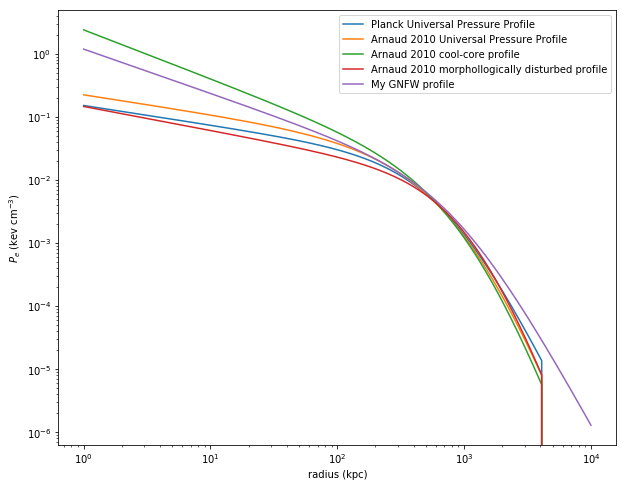

In [48]:
# How to change the pressure model

plt.figure(figsize=(10,8))

# We can use standard profiles based on mass and redshift
clust.set_pressure_gas_gNFW_param('P13UPP')
r, p_r = clust.get_pressure_gas_profile()
plt.loglog(r, p_r, label='Planck Universal Pressure Profile')
clust.set_pressure_gas_gNFW_param('A10UPP')
r, p_r = clust.get_pressure_gas_profile()
plt.loglog(r, p_r, label='Arnaud 2010 Universal Pressure Profile')
clust.set_pressure_gas_gNFW_param('A10CC')
r, p_r = clust.get_pressure_gas_profile()
plt.loglog(r, p_r, label='Arnaud 2010 cool-core profile')
clust.set_pressure_gas_gNFW_param('A10MD')
r, p_r = clust.get_pressure_gas_profile()
plt.loglog(r, p_r, label='Arnaud 2010 morphollogically disturbed profile')

# Note that we can redefine the truncation, e.g., no truncation, and define our own profile
clust.R_truncation = np.inf*u.kpc
clust.pressure_gas_model = {'name':'GNFW', 'P_0':1e-2*u.keV/u.cm**3, 'c500':1.5, 'a':1.3, 'b':3.7, 'c':0.7}
r, p_r = clust.get_pressure_gas_profile()
plt.loglog(r, p_r, label='My GNFW profile')

plt.xlabel('radius (kpc)')
plt.ylabel('$P_e$ (kev cm$^{-3}$)')
plt.legend()

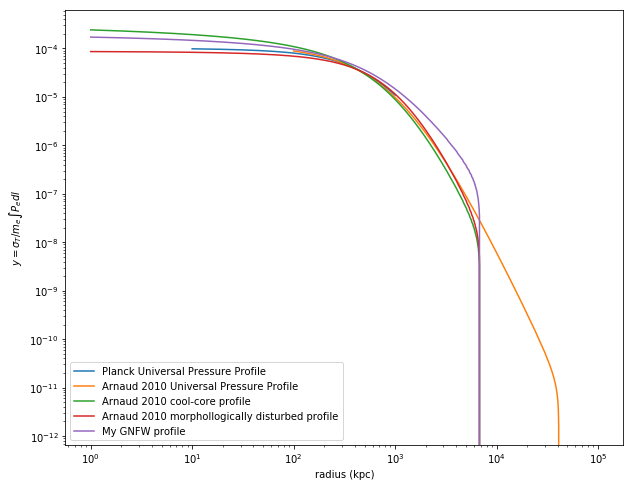

In [55]:
# How to derive the Compton parameter profile

plt.figure(figsize=(10,8))

clust.set_pressure_gas_gNFW_param('P13UPP')
# Note that we can pass a user defined radius
radius = np.logspace(1,3,1000)*u.kpc 
r, y_r = clust.get_y_compton_profile(radius)
plt.loglog(r, y_r, label='Planck Universal Pressure Profile')

# by default, the line of sight integration stops at 5R500, but we can change that
clust.set_pressure_gas_gNFW_param('A10UPP')
r, y_r = clust.get_y_compton_profile(np.logspace(2,5,1000)*u.kpc, NR500max=30.0, Npt_los=1000)
plt.loglog(r, y_r, label='Arnaud 2010 Universal Pressure Profile')

clust.set_pressure_gas_gNFW_param('A10CC')
r, y_r = clust.get_y_compton_profile()
plt.loglog(r, y_r, label='Arnaud 2010 cool-core profile')

clust.set_pressure_gas_gNFW_param('A10MD')
r, y_r = clust.get_y_compton_profile()
plt.loglog(r, y_r, label='Arnaud 2010 morphollogically disturbed profile')

clust.pressure_gas_model = {'name':'GNFW', 'P_0':1e-2*u.keV/u.cm**3, 'c500':1.5, 'a':1.3, 'b':3.7, 'c':0.7}
r, y_r = clust.get_y_compton_profile()
plt.loglog(r, y_r, label='My GNFW profile')

plt.xlabel('radius (kpc)')
plt.ylabel('$y = \\sigma_T/m_e \int P_e dl$')
plt.legend()

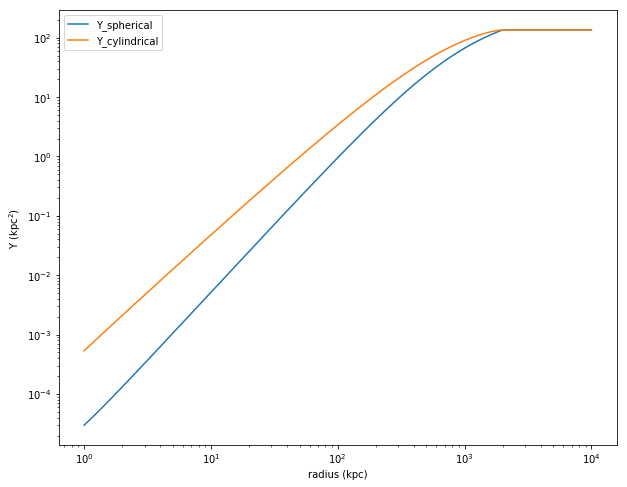

In [58]:
# How to derive the integrated profiles

clust.R_truncation = 2000*u.kpc
clust.pressure_gas_model = {'name':'GNFW', 'P_0':1e-2*u.keV/u.cm**3, 'c500':1.5, 'a':1.3, 'b':3.7, 'c':0.7}

plt.figure(figsize=(10,8))
# either the spherically integrated SZ flux
r, y_r = clust.get_ysph_profile()
plt.loglog(r, y_r, label='Y_spherical')

# or the cylindrically integrated
r, y_r = clust.get_ycyl_profile()
plt.loglog(r, y_r, label='Y_cylindrical')

plt.xlabel('radius (kpc)')
plt.ylabel('Y (kpc$^2$)')
plt.legend()

# Note that because of truncation, the Y profile remain constant beyond R_truncation
# At r = infinity, the sphercial and cylindrical profile should converge

# Extract the Compton parameter map from Planck

In [76]:
# Lets first define the directory where we have put the Planck y_map
dat_dir = os.getenv('CTAPHYS_EDAT_DIR')
ymap_file  = dat_dir+'/Planck/COM_CompMap_Compton-SZMap-milca-ymaps_2048_R2.00.fits'

# We can play with the map size and resolution of our map
clust.map_fov = 6*u.deg
clust.map_reso = 1*u.arcmin

ymap, header = map_tools.roi_extract_healpix(ymap_file, clust.coord.ra.value, clust.coord.dec.value, 
                                   clust.map_reso.to_value('deg'), 
                                             [clust.map_fov[0].to_value('deg'), clust.map_fov[1].to_value('deg')],
                                             visu=False)

# We can also set the header of our model to a given map (to have pixel-pixel comparison)
clust.map_header = header

Text(0.5,1,'Coma Planck map, y x $10^6$')

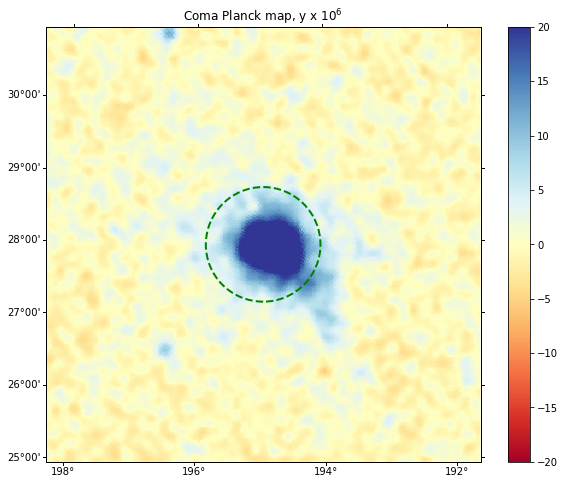

In [75]:
fig = plt.figure(figsize=(10, 8))
rad = clust.theta500.to_value('deg')
ax = plt.subplot(111, projection=WCS(header))
plt.imshow(1e6*ymap, vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((clust.coord.ra.value, clust.coord.dec.value),
                                        2*rad/np.cos(clust.coord.dec.value*np.pi/180), 2*rad,
                                        linewidth=2, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.colorbar()
plt.title(clust.name+' Planck map, y x $10^6$')

# Compute a model ymap

In [81]:
# Let's get a ymap, and smooth it to the Planck Beam for comparison
ymodel = (clust.get_ymap(FWHM=10*u.arcmin)).value

Text(0.5,1,'Coma Model map, y x $10^6$')

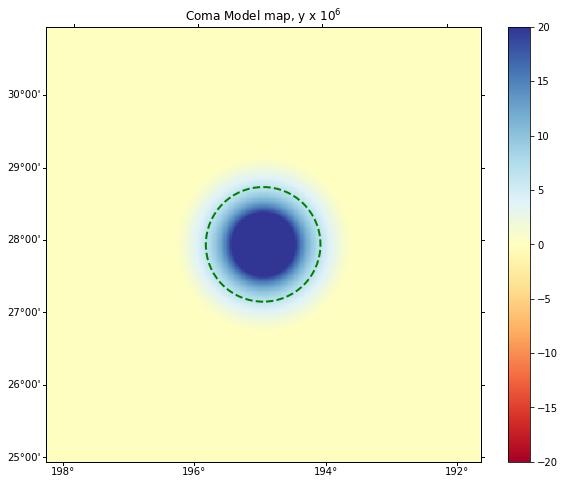

In [82]:
fig = plt.figure(figsize=(10, 8))
rad = clust.theta500.to_value('deg')
ax = plt.subplot(111, projection=WCS(header))
plt.imshow(1e6*ymodel, vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((clust.coord.ra.value, clust.coord.dec.value),
                                        2*rad/np.cos(clust.coord.dec.value*np.pi/180), 2*rad,
                                        linewidth=2, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.colorbar()
plt.title(clust.name+' Model map, y x $10^6$')

Text(0.5,1,'Coma low mass model map, y x $10^6$')

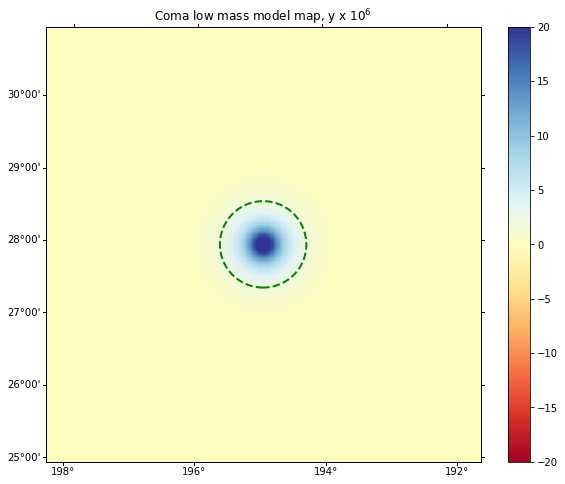

In [85]:
# Let see how the model affect the map by setting a low mass and using the UPP
clust.M500 = 3e14*u.Msun
clust.set_pressure_gas_gNFW_param('P13UPP')
ymodel = (clust.get_ymap(FWHM=10*u.arcmin)).value

fig = plt.figure(figsize=(10, 8))
rad = clust.theta500.to_value('deg')
ax = plt.subplot(111, projection=WCS(header))
plt.imshow(1e6*ymodel, vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((clust.coord.ra.value, clust.coord.dec.value),
                                        2*rad/np.cos(clust.coord.dec.value*np.pi/180), 2*rad,
                                        linewidth=2, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.colorbar()
plt.title(clust.name+' low mass model map, y x $10^6$')

# Fit the parameters (amplitude and concentraction)

In [165]:
# Defines model
def model(clust, params):
    P_0  = params[0]
    c500 = params[1]
    clust.pressure_gas_model = {'name':'GNFW', 'P_0':P_0*u.keV/u.cm**3, 'c500':c500, 'a':1.8, 'b':3.1, 'c':0.0}
    ymod = (clust.get_ymap(FWHM=10*u.arcmin)).value
    return ymod

# Defines log likelihood
def lnlike(params, clust, data, err) :
    mod = model(clust, params)
    chi2 = ((data - mod)**2) / (err**2)
    # Put prior on parameters >0 here
    if params[0] > 0 and params[1] > 0:
        return -0.5*np.sum(chi2)
    else:
        return -np.inf

In [166]:
# Run the MCMC
clust.R500 = 1.31*u.Mpc # Since we fir for c500, R500 should be defined (from Planck2013 Coma paper)

data = ymap
err = ymap*0 + np.std(ymap) # First guess for errors
for i in [1,2,3,4,5,6]: err = ymap*0 + np.std(ymap[ymap/err < 5]) # Refine error, but still no covariance here
par0 = np.array([2.0e-2, 3.0]) # guess parameters
    
ndim, nwalkers, nsteps, burnin = len(par0), 10, 2000, 100

nwalkers = 10
ndim = len(par0)
pos = [par0 + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, a=2.0, args=[clust, data, err], threads=4)
sampler.run_mcmc(pos, nsteps)
param_chains = sampler.chain[:, burnin:, :]

KeyboardInterrupt: 

In [152]:
# Get the best fit parameters
wbest = sampler.lnprobability == np.amax(sampler.lnprobability)
p0_best = ((sampler.chain[:,:,0])[wbest])[0]
c500_best = ((sampler.chain[:,:,1])[wbest])[0]

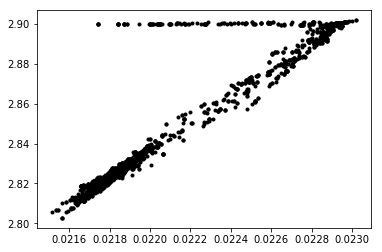

In [154]:
plt.plot(sampler.chain[:,:,0], sampler.chain[:,:,1], '.k')

[0.02177473 2.82214806]


Text(0.5,1,'Coma best model map, y x $10^6$')

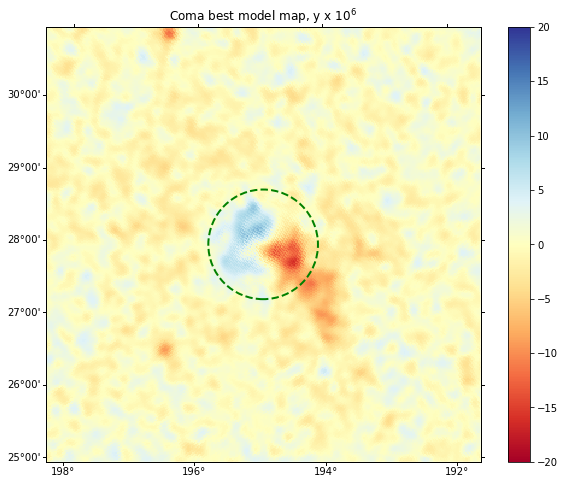

In [162]:
ybest = model(clust, np.array([p0_best[0], c500_best[0]]))

fig = plt.figure(figsize=(10, 8))
rad = clust.theta500.to_value('deg')
ax = plt.subplot(111, projection=WCS(header))
plt.imshow(1e6*(ybest-ymap), vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((clust.coord.ra.value, clust.coord.dec.value),
                                        2*rad/np.cos(clust.coord.dec.value*np.pi/180), 2*rad,
                                        linewidth=2, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.colorbar()
plt.title(clust.name+' best model map, y x $10^6$')